# COS 801
## Assignment 1
### Thabo Chesane


# Imports 


In [ ]:

import os, random, warnings, math
warnings.filterwarnings("ignore")

import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import re
from plotly.subplots import make_subplots

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier
    XGB_AVAILABLE = False
    print("xgboost not found; using GradientBoostingClassifier as the fallback.")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

ROOT       = os.getcwd()
TRAIN_DIR  = os.path.join(ROOT, "train")
VAL_DIR    = None       
TEST_DIR   = os.path.join(ROOT, "test")   
USE_SPLIT  = True       
IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 25
AUTOTUNE   = tf.data.AUTOTUNE


CLASS_NAMES = [
    "Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen",
    "Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse",
    "Small-flowered Cranesbill","Sugar beet"
]
print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.19.0



# Data loading utilities


In [28]:

def list_class_folders(root, allowed):
    found = []
    for d in sorted(os.listdir(root)):
        p = os.path.join(root, d)
        if os.path.isdir(p) and d in allowed:
            found.append(d)
    if not found:
        raise RuntimeError(f"No valid class folders in {root}. Expected one or more of: {allowed}")
    return found

CLASS_NAMES = list_class_folders(TRAIN_DIR, CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)
print(f"Detected {NUM_CLASSES} classes:\n{CLASS_NAMES}")

def make_ds_from_directory(path, subset=None, validation_split=None, shuffle=True, seed=SEED):
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=CLASS_NAMES,         
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=seed,
        validation_split=validation_split,
        subset=subset,
    )

if USE_SPLIT or not VAL_DIR:
    train_ds = make_ds_from_directory(TRAIN_DIR, subset="training",   validation_split=0.20, shuffle=True)
    val_ds   = make_ds_from_directory(TRAIN_DIR, subset="validation", validation_split=0.20, shuffle=False)
else:
    train_ds = make_ds_from_directory(TRAIN_DIR, shuffle=True)
    val_ds   = make_ds_from_directory(VAL_DIR,   shuffle=False)

def prepare(ds, training=False):
    ds = ds.cache()
    if training: ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds,   training=False)

Detected 12 classes:
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Found 4750 files belonging to 12 classes.
Using 3800 files for training.
Found 4750 files belonging to 12 classes.
Using 950 files for validation.



# Baseline CNN definition


In [29]:

def make_activation(name: str):
    name = (name or "relu").lower()
    if name == "relu":
        return layers.ReLU()
    if name == "leakyrelu":
        return layers.LeakyReLU(alpha=0.1)
    if name == "prelu":
        
        return layers.PReLU(shared_axes=[1, 2])
    if name == "elu":
        return layers.ELU(alpha=1.0)
    if name == "gelu":
        return layers.Activation(tf.nn.gelu)
    if name in ("silu", "swish"):
        
        return layers.Activation(tf.nn.silu)
    if name == "mish":
        # mish(x) = x * tanh(softplus(x))
        return layers.Lambda(lambda x: x * tf.math.tanh(tf.math.softplus(x)))
    if name == "selu":
        # handled specially inside build_cnn (no BatchNorm; AlphaDropout; LeCun init)
        return layers.Activation("selu")
    raise ValueError(f"Unknown activation '{name}'")

def conv_block(x, filters, activation_layer, use_bn=True, kernel_init="he_normal"):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=not use_bn,
                      kernel_initializer=kernel_init)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation_layer(x)
    return layers.MaxPooling2D()(x)

def build_cnn(input_shape=(224, 224, 3), num_classes=12, activation="relu"):
    """
    activation: one of
        'relu', 'leakyrelu', 'prelu', 'elu', 'gelu', 'silu'/'swish', 'mish', 'selu'
    Notes:
      • For 'selu' we switch to LeCun init, remove BatchNorm, and use AlphaDropout.
      • For others we keep BatchNorm + standard Dropout.
    """
    act_name = (activation or "relu").lower()
    use_selu_path = (act_name == "selu")

    inputs = keras.Input(shape=input_shape)

    # Data pipeline
    aug = keras.Sequential(
        [layers.RandomFlip("horizontal"),
         layers.RandomRotation(0.10),
         layers.RandomZoom(0.10)],
        name="augment",
    )
    x = aug(inputs)

    if use_selu_path:
       
        x = layers.Rescaling(1./127.5, offset=-1.0)(x)
        act = make_activation("selu")
        kernel_init = "lecun_normal"
        use_bn = False
        dropout = lambda rate: layers.AlphaDropout(rate)
    else:
        x = layers.Rescaling(1./255)(x)
        act = make_activation(act_name)
        kernel_init = "he_normal"
        use_bn = True
        dropout = lambda rate: layers.Dropout(rate)

    # Feature extractor
    x = conv_block(x, 32,  activation_layer=act, use_bn=use_bn, kernel_init=kernel_init)
    x = conv_block(x, 64,  activation_layer=act, use_bn=use_bn, kernel_init=kernel_init)
    x = conv_block(x, 128, activation_layer=act, use_bn=use_bn, kernel_init=kernel_init)

    x = layers.GlobalAveragePooling2D()(x)
    x = dropout(0.30)(x)

  
    x = layers.Dense(256, kernel_initializer=kernel_init, name="embedding")(x)
    x = act(x)
    x = dropout(0.30)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="classifier")(x)
    return keras.Model(inputs, outputs, name=f"cnn_{act_name}")


In [30]:

cnn = build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES, activation="relu")
     

cnn.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="categorical_crossentropy",
            metrics=["accuracy"])


callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
]

history = cnn.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

Epoch 1/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - accuracy: 0.3334 - loss: 2.0198 - val_accuracy: 0.0000e+00 - val_loss: 3.7363 - learning_rate: 0.0010
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 470ms/step - accuracy: 0.4750 - loss: 1.5426 - val_accuracy: 0.0021 - val_loss: 4.2211 - learning_rate: 0.0010
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 473ms/step - accuracy: 0.5305 - loss: 1.3755 - val_accuracy: 0.1632 - val_loss: 2.4717 - learning_rate: 0.0010
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 57s 481ms/step - accuracy: 0.5779 - loss: 1.2602 - val_accuracy: 0.6863 - val_loss: 1.1057 - learning_rate: 0.0010
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 58s 489ms/step - accuracy: 0.6053 - loss: 1.1725 - val_accuracy: 0.6811 - val_loss: 1.2115 - learning_rate: 0.0010
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 59s 498ms/step - accuracy: 0.6329 - loss: 1.0909 - val_accuracy: 0.6526 - val_loss: 1.0549 - learning_rate: 0.0010
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 473ms/step - accuracy:


# Utilities for predictions, features, metrics


In [31]:

def ds_to_numpy(ds):
    xs, ys = [], []
    for xb, yb in ds:
        xs.append(xb.numpy())
        ys.append(yb.numpy())
    return np.concatenate(xs, 0), np.concatenate(ys, 0)

def preds_and_labels(model, ds):
    y_prob = model.predict(ds, verbose=0)
    _, y_true_onehot = ds_to_numpy(ds)
    y_true_idx = np.argmax(y_true_onehot, axis=1)
    y_pred_idx = np.argmax(y_prob, axis=1)
    return y_true_idx, y_pred_idx, y_prob

def extract_features(ds, feature_model):
    feats, labels = [], []
    for xb, yb in ds:
        z = feature_model.predict(xb, verbose=0)
        feats.append(z)
        labels.append(yb.numpy())
    X = np.concatenate(feats, 0)
    Y = np.concatenate(labels, 0)
    y_idx = np.argmax(Y, axis=1)
    return X, y_idx

def micro_roc_auc(y_true_idx, y_prob, num_classes):
    y_true_bin = label_binarize(y_true_idx, classes=np.arange(num_classes))
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    return fpr, tpr, auc(fpr, tpr)

# VALIDATION comparison — Baseline CNN vs CNN+SVM vs CNN+XGB


In [32]:


y_true_val, y_pred_val_cnn, y_prob_val_cnn = preds_and_labels(cnn, val_ds)
f1_micro_cnn_val = f1_score(y_true_val, y_pred_val_cnn, average="micro")


feature_extractor = keras.Model(inputs=cnn.input, outputs=cnn.get_layer("embedding").output)
Xtr, ytr = extract_features(train_ds, feature_extractor)
Xva, yva = extract_features(val_ds,   feature_extractor)


svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True, random_state=SEED))
svm_clf.fit(Xtr, ytr)
y_pred_val_svm = svm_clf.predict(Xva)
y_prob_val_svm = svm_clf.predict_proba(Xva)
f1_micro_svm_val = f1_score(yva, y_pred_val_svm, average="micro")


if XGB_AVAILABLE:
    xgb_clf = XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", num_class=NUM_CLASSES,
        eval_metric="mlogloss", tree_method="hist", random_state=SEED
    )
else:
    xgb_clf = GradientBoostingClassifier(random_state=SEED)

xgb_clf.fit(Xtr, ytr)
y_pred_val_xgb = xgb_clf.predict(Xva)
y_prob_val_xgb = xgb_clf.predict_proba(Xva)
f1_micro_xgb_val = f1_score(yva, y_pred_val_xgb, average="micro")
xgb_name = "XGBoost" if XGB_AVAILABLE else "GradientBoosting (fallback)"

print(f"CNN        — micro F1: {f1_micro_cnn_val:.4f}")
print(f"CNN & SVM           — micro F1: {f1_micro_svm_val:.4f}")
print(f"CNN & {xgb_name:23} — micro F1: {f1_micro_xgb_val:.4f}")

2025-08-24 00:04:59.623059: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


CNN        — micro F1: 0.8021
CNN & SVM           — micro F1: 0.8853
CNN & XGBoost                 — micro F1: 0.9821



# VALIDATION micro-ROC plotting


In [33]:
# Fallback if micro_roc_auc isn't already defined in your notebook
try:
    micro_roc_auc
except NameError:
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    def micro_roc_auc(y_true_idx, y_prob, num_classes):
        y_true_bin = label_binarize(y_true_idx, classes=np.arange(num_classes))
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
        return fpr, tpr, auc(fpr, tpr)

# Compute curves here to avoid NameError
fpr_cnn_v, tpr_cnn_v, auc_cnn_v = micro_roc_auc(y_true_val, y_prob_val_cnn, NUM_CLASSES)
fpr_svm_v, tpr_svm_v, auc_svm_v = micro_roc_auc(yva,        y_prob_val_svm, NUM_CLASSES)
fpr_xgb_v, tpr_xgb_v, auc_xgb_v = micro_roc_auc(yva,        y_prob_val_xgb, NUM_CLASSES)

# Detect activation used by the CNN (build_cnn names model like "cnn_{activation}")
act_label = "CNN"
try:
    mname = getattr(cnn, "name", "") or ""
    act_label = f"CNN ({mname.split('cnn_', 1)[1]})" if "cnn_" in mname else "CNN"
except Exception:
    pass

fig = go.Figure()

def add_curve(fpr, tpr, label, auc_value):
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr, mode="lines",
        name=f"{label} (AUC={auc_value:.3f})",
        hovertemplate="FPR=%{x:.3f}<br>TPR=%{y:.3f}<extra>"+label+"</extra>",
    ))

add_curve(fpr_cnn_v, tpr_cnn_v, act_label,            auc_cnn_v)
add_curve(fpr_svm_v, tpr_svm_v, "CNN + SVM",          auc_svm_v)
add_curve(fpr_xgb_v, tpr_xgb_v, f"CNN + {xgb_name}",  auc_xgb_v)

# Chance line
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1], mode="lines", name="Chance",
    line=dict(dash="dash"), hoverinfo="skip"
))

fig.update_layout(
    width=720, height=600, template="plotly_white",
    title="Validation — Micro-averaged ROC (multi-class)",
    xaxis=dict(title="False Positive Rate", range=[0, 1], showgrid=True, zeroline=False),
    yaxis=dict(title="True Positive Rate",  range=[0, 1], showgrid=True, zeroline=False),
    legend=dict(x=0.99, y=0.01, xanchor="right", yanchor="bottom", bgcolor="rgba(255,255,255,0.6)")
)
fig.show()

# --- Metrics table (sorted by micro F1) ---
df = pd.DataFrame({
    "Model": [act_label, "CNN + SVM", f"CNN + {xgb_name}"],
    "F1_micro (VAL)": [f1_micro_cnn_val, f1_micro_svm_val, f1_micro_xgb_val],
    "ROC_AUC_micro (VAL)": [auc_cnn_v, auc_svm_v, auc_xgb_v],
}).sort_values("F1_micro (VAL)", ascending=False)

table = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns), align="left"),
    cells=dict(values=[df[c].round(3) if df[c].dtype.kind in "fc" else df[c] for c in df.columns], align="left"),
)])
table.update_layout(width=720)
table.show()

# If you also want the pandas view:
display(df)

,Model,F1_micro (VAL),ROC_AUC_micro (VAL)
2,CNN + XGBoost,0.982105,0.999569
1,CNN + SVM,0.885263,0.995582
0,CNN (relu),0.802105,0.982522


# TEST: inference on flat folder + optional metrics/ROC


In [34]:
def load_unlabeled_images(folder: Path, img_size: int):
    exts = {".jpg",".jpeg",".png",".bmp",".gif",".webp"}
    files, imgs = [], []
    for p in sorted(folder.rglob("*")):
        if p.is_file() and p.suffix.lower() in exts:
            try:
                img = keras.utils.load_img(p, target_size=(img_size, img_size))
                arr = keras.utils.img_to_array(img)  # float32 [0,255]
                imgs.append(arr); files.append(p.name)
            except Exception as e:
                print(f"Skipping {p}: {e}")
    if not imgs:
        raise RuntimeError(f"No images found in {folder.resolve()}")
    return files, np.stack(imgs, 0).astype("float32")


TEST_DIR_PATH = Path(TEST_DIR)
files_test, Xtest = load_unlabeled_images(TEST_DIR_PATH, IMG_SIZE)
ds_unlab = tf.data.Dataset.from_tensor_slices(Xtest).batch(BATCH_SIZE).prefetch(AUTOTUNE)


prob_cnn_t = cnn.predict(ds_unlab, verbose=0)               
pred_cnn_t = prob_cnn_t.argmax(1)
top_cnn_t  = prob_cnn_t.max(1)


Ztest = feature_extractor.predict(ds_unlab, verbose=0)      

prob_svm_t = svm_clf.predict_proba(Ztest)
pred_svm_t = prob_svm_t.argmax(1)
top_svm_t  = prob_svm_t.max(1)

prob_xgb_t = xgb_clf.predict_proba(Ztest)
pred_xgb_t = prob_xgb_t.argmax(1)
top_xgb_t  = prob_xgb_t.max(1)


model_tag = "XGBoost" if XGB_AVAILABLE else "GradientBoosting"
pred_df = pd.DataFrame({
    "file": files_test,
    "CNN_pred": [CLASS_NAMES[i] for i in pred_cnn_t],
    "CNN_conf": top_cnn_t,
    "SVM_pred": [CLASS_NAMES[i] for i in pred_svm_t],
    "SVM_conf": top_svm_t,
    f"{model_tag}_pred": [CLASS_NAMES[i] for i in pred_xgb_t],
    f"{model_tag}_conf": top_xgb_t,
}).sort_values("file").reset_index(drop=True)


out_path = Path("results.csv")
pred_df.to_csv(out_path, index=False)
print(f"\nPredictions generated for {len(files_test)} images in ./test")
print(f"Saved results to: {out_path.resolve()}")
display(pred_df.head(20))


Predictions generated for 794 images in ./test
Saved results to: /Users/thabochesane/Documents/Big Data Science/2025/COS 801/A1/results.csv


,file,CNN_pred,CNN_conf,SVM_pred,SVM_conf,XGBoost_pred,XGBoost_conf
0,0021e90e4.png,Small-flowered Cranesbill,0.680030,Small-flowered Cranesbill,0.963775,Small-flowered Cranesbill,0.995530
1,003d61042.png,Fat Hen,0.600340,Fat Hen,0.841038,Fat Hen,0.998104
2,007b3da8b.png,Cleavers,0.308156,Sugar beet,0.832475,Sugar beet,0.946841
3,0086a6340.png,Common Chickweed,0.991308,Common Chickweed,0.990630,Common Chickweed,0.999274
4,00c47e980.png,Sugar beet,0.677427,Sugar beet,0.914207,Sugar beet,0.995552
5,00d090cde.png,Loose Silky-bent,0.495738,Loose Silky-bent,0.851072,Loose Silky-bent,0.996004
6,00ef713a8.png,Common Chickweed,0.971383,Common Chickweed,0.983821,Common Chickweed,0.998711
7,01291174f.png,Fat Hen,0.891973,Fat Hen,0.974418,Fat Hen,0.999468
8,026716f9b.png,Loose Silky-bent,0.433986,Loose Silky-bent,0.771257,Loose Silky-bent,0.943957
9,02cfeb38d.png,Loose Silky-bent,0.581678,Loose Silky-bent,0.908872,Loose Silky-bent,0.996323


# Visualizing model confidences & predictions from results.csv
# - Composite figure: confidence distribution + per-class prediction counts


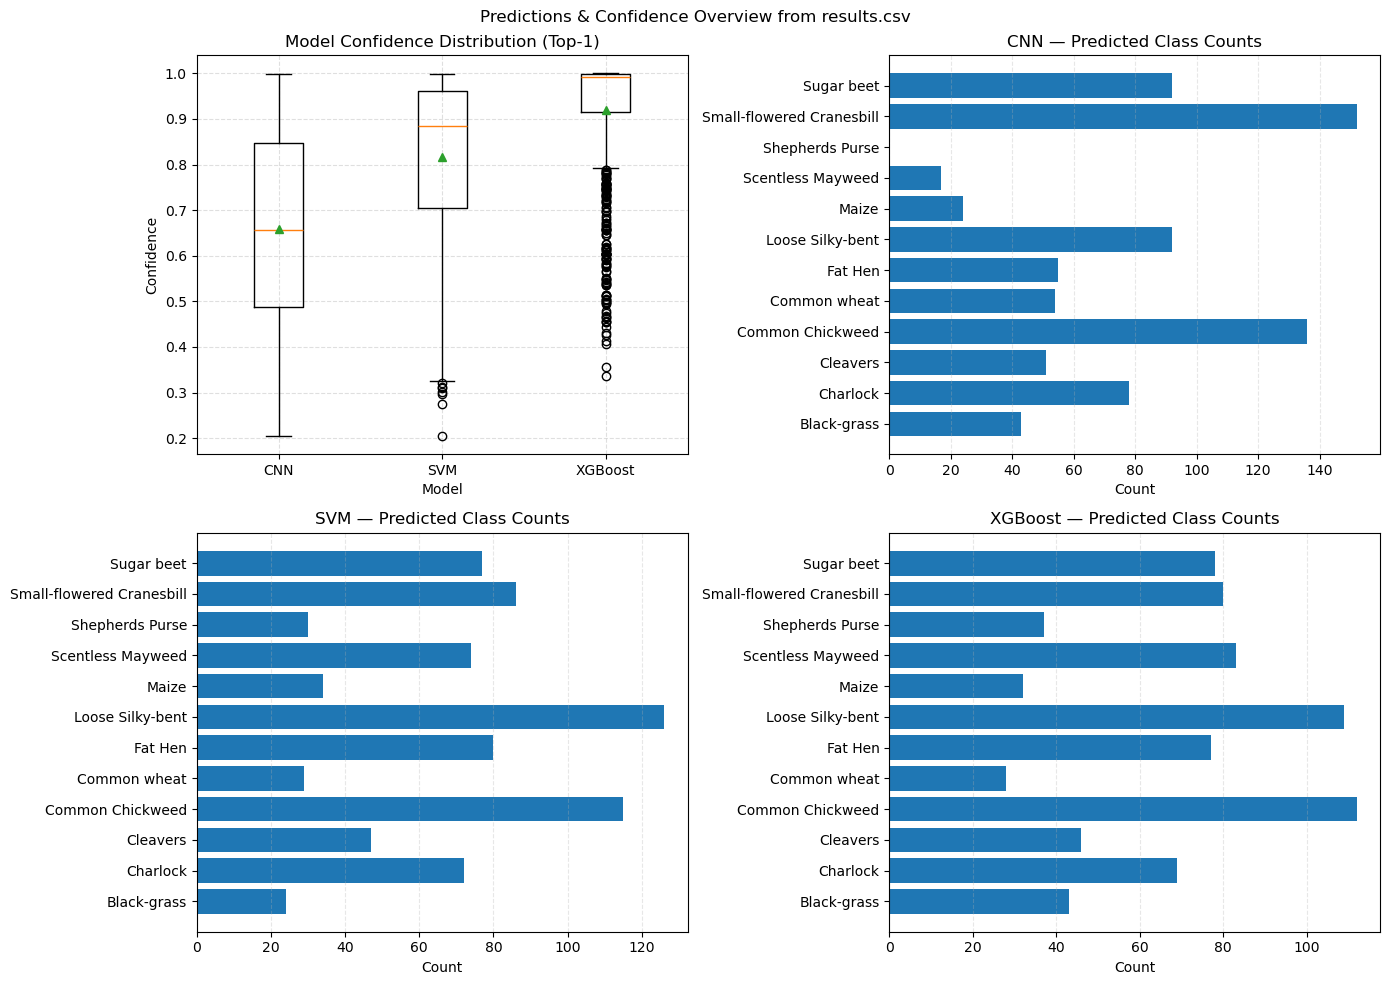

,count,mean,median,std
model,,,,
XGBoost,794,0.919637,0.991760,0.139140
SVM,794,0.817503,0.885243,0.177840
CNN,794,0.659175,0.657148,0.205471


,file,model,pred,conf
2231,cd6adba97.png,XGBoost,Small-flowered Cranesbill,0.999729
2049,93d76fd5d.png,XGBoost,Small-flowered Cranesbill,0.999694
2209,c6b76307d.png,XGBoost,Cleavers,0.999668
1802,44e8b8833.png,XGBoost,Small-flowered Cranesbill,0.999663
2145,b1cd2a91e.png,XGBoost,Cleavers,0.999650
2321,e9cd91682.png,XGBoost,Common Chickweed,0.999647
1617,08d591441.png,XGBoost,Sugar beet,0.999646
2098,a38b8a581.png,XGBoost,Small-flowered Cranesbill,0.999644
1948,754b1adf8.png,XGBoost,Small-flowered Cranesbill,0.999633
2000,855955aaf.png,XGBoost,Small-flowered Cranesbill,0.999613


In [35]:



csv_path = Path("results.csv")
if not csv_path.exists():
    raise FileNotFoundError("results.csv not found. Run the inference cell that saves results.csv first.")

df = pd.read_csv(csv_path)


pred_cols = [c for c in df.columns if c.endswith("_pred")]
conf_cols = [c for c in df.columns if c.endswith("_conf")]


expected = {"CNN_pred", "SVM_pred"}
if not expected.issubset(set(pred_cols)) or len(pred_cols) != 3:
    raise ValueError(
        "Unexpected columns in results.csv. Expected 'CNN_pred', 'SVM_pred', and one of "
        "'XGBoost_pred'/'GradientBoosting_pred' (with matching *_conf columns)."
    )

third_model_pred = [c for c in pred_cols if c not in expected][0]
third_model_name = third_model_pred.replace("_pred","")
third_model_conf = third_model_name + "_conf"


long_rows = []
for mdl, pcol, ccol in [
    ("CNN", "CNN_pred", "CNN_conf"),
    ("SVM", "SVM_pred", "SVM_conf"),
    (third_model_name, third_model_pred, third_model_conf),
]:
   
    if pcol not in df.columns or ccol not in df.columns:
        continue
    for f, pred, conf in zip(df["file"], df[pcol], df[ccol]):
        long_rows.append((f, mdl, str(pred), float(conf)))

long_df = pd.DataFrame(long_rows, columns=["file","model","pred","conf"])


if "CLASS_NAMES" in globals() and isinstance(CLASS_NAMES, (list, tuple)) and len(CLASS_NAMES) > 0:
    classes = list(CLASS_NAMES)
else:
    classes = sorted(long_df["pred"].unique())


def counts_for_model(model_name):
    subset = long_df[long_df["model"] == model_name]
    counts = subset["pred"].value_counts()
    
    return pd.Series({cls: counts.get(cls, 0) for cls in classes})


cnt_cnn = counts_for_model("CNN")
cnt_svm = counts_for_model("SVM")
cnt_third = counts_for_model(third_model_name)


fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2)


axA = fig.add_subplot(gs[0, 0])

models_in_order = ["CNN", "SVM", third_model_name]
data_box = [long_df.loc[long_df["model"]==m, "conf"].values for m in models_in_order]
axA.boxplot(data_box, labels=models_in_order, showmeans=True)
axA.set_title("Model Confidence Distribution (Top-1)")
axA.set_ylabel("Confidence")
axA.set_xlabel("Model")
axA.grid(True, linestyle="--", alpha=0.4)


axB = fig.add_subplot(gs[0, 1])
axB.barh(classes, cnt_cnn[classes].values)
axB.set_title("CNN — Predicted Class Counts")
axB.set_xlabel("Count")
axB.grid(True, axis="x", linestyle="--", alpha=0.3)


axC = fig.add_subplot(gs[1, 0])
axC.barh(classes, cnt_svm[classes].values)
axC.set_title("SVM — Predicted Class Counts")
axC.set_xlabel("Count")
axC.grid(True, axis="x", linestyle="--", alpha=0.3)


axD = fig.add_subplot(gs[1, 1])
axD.barh(classes, cnt_third[classes].values)
axD.set_title(f"{third_model_name} — Predicted Class Counts")
axD.set_xlabel("Count")
axD.grid(True, axis="x", linestyle="--", alpha=0.3)

fig.suptitle("Predictions & Confidence Overview from results.csv", y=0.98)
fig.tight_layout()
plt.show()


summary_conf = (long_df
                .groupby("model")["conf"]
                .agg(["count","mean","median","std"])
                .sort_values("mean", ascending=False))
display(summary_conf)


display(long_df.sort_values("conf", ascending=False).head(10))



# Single-image demo: generate an image and predict with all models
# Reuses: cnn, feature_extractor, svm_clf, xgb_clf, CLASS_NAMES, IMG_SIZE, XGB_AVAILABLE


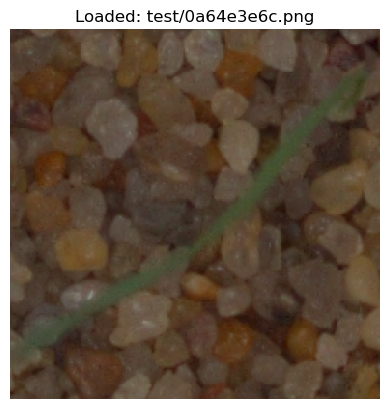

,Model,Top-1 Label,Confidence
0,Baseline CNN,Common wheat,0.633456
1,CNN + SVM,Black-grass,0.585543
2,CNN + XGBoost,Black-grass,0.970743



Top-5 predictions per model:

Baseline CNN:
  Common wheat                   0.6335
  Black-grass                    0.2183
  Loose Silky-bent               0.1122
  Fat Hen                        0.0220
  Sugar beet                     0.0090

CNN + SVM:
  Black-grass                    0.5855
  Loose Silky-bent               0.3412
  Common wheat                   0.0401
  Fat Hen                        0.0138
  Sugar beet                     0.0067

CNN + XGBoost:
  Black-grass                    0.9707
  Loose Silky-bent               0.0133
  Fat Hen                        0.0046
  Sugar beet                     0.0035
  Common wheat                   0.0025


In [ ]:



# Optional: instead of generating, set a real image path (e.g., one from ./test)
OVERRIDE_IMG_PATH = "test/0a64e3e6c.png"  # e.g., "test/example.jpg"

def load_and_resize(path, size=224):
    img = keras.utils.load_img(path, target_size=(size, size))
    return np.array(img).astype("float32")

def make_synthetic_leafy(size=224, seed=42):
    """
    Creates a simple green-tinted, textured image to mimic foliage-ish patterns.
    Not a real plant photo, but useful to test the full inference pipeline.
    """
    rng = np.random.RandomState(seed)
   
    img = rng.normal(loc=0.5, scale=0.2, size=(size, size, 3))
    img = np.clip(img, 0, 1)
    
    tint = np.array([0.20, 0.80, 0.20])[None, None, :]
    img = np.clip(0.6 * img + 0.4 * tint, 0, 1)
    
    pil = Image.fromarray((img * 255).astype(np.uint8))
    draw = ImageDraw.Draw(pil)
    for _ in range(30):
        x0, y0 = rng.randint(0, size, 2)
        x1 = np.clip(x0 + rng.randint(-40, 41), 0, size - 1)
        y1 = np.clip(y0 + rng.randint(-40, 41), 0, size - 1)
        draw.line((x0, y0, x1, y1), fill=(20, 80, 20), width=int(rng.randint(1, 3)))
    pil = pil.filter(ImageFilter.GaussianBlur(radius=1))
    return np.array(pil).astype("float32")

if OVERRIDE_IMG_PATH:
    img = load_and_resize(OVERRIDE_IMG_PATH, IMG_SIZE)
    title = f"Loaded: {OVERRIDE_IMG_PATH}"
else:
    img = make_synthetic_leafy(IMG_SIZE, seed=42)
    title = "Synthetic 'leafy' image (demo)"


x = np.expand_dims(img, 0)  


prob_cnn = cnn.predict(x, verbose=0)[0]            
pred_cnn_idx = int(prob_cnn.argmax())
pred_cnn_lbl = CLASS_NAMES[pred_cnn_idx]
conf_cnn = float(prob_cnn.max())


Z = feature_extractor.predict(x, verbose=0)        
prob_svm = svm_clf.predict_proba(Z)[0]
pred_svm_idx = int(prob_svm.argmax())
pred_svm_lbl = CLASS_NAMES[pred_svm_idx]
conf_svm = float(prob_svm.max())

prob_xgb = xgb_clf.predict_proba(Z)[0]
pred_xgb_idx = int(prob_xgb.argmax())
pred_xgb_lbl = CLASS_NAMES[pred_xgb_idx]
conf_xgb = float(prob_xgb.max())
xgb_name = "XGBoost" if XGB_AVAILABLE else "GradientBoosting"


def topk(prob, k=5):
    idx = np.argsort(prob)[::-1][:k]
    return [(CLASS_NAMES[i], float(prob[i])) for i in idx]

topk_cnn = topk(prob_cnn, k=min(5, len(CLASS_NAMES)))
topk_svm = topk(prob_svm, k=min(5, len(CLASS_NAMES)))
topk_xgb = topk(prob_xgb, k=min(5, len(CLASS_NAMES)))


plt.figure(figsize=(4.8, 4.8))
plt.imshow(img.astype("uint8"))
plt.axis("off")
plt.title(title)
plt.show()

import pandas as pd
summary_single = pd.DataFrame({
    "Model": ["Baseline CNN", "CNN + SVM", f"CNN + {xgb_name}"],
    "Top-1 Label": [pred_cnn_lbl, pred_svm_lbl, pred_xgb_lbl],
    "Confidence": [conf_cnn, conf_svm, conf_xgb],
})
display(summary_single)

print("\nTop-5 predictions per model:\n")
print("Baseline CNN:")
for cls, p in topk_cnn: print(f"  {cls:28s}  {p:7.4f}")
print("\nCNN + SVM:")
for cls, p in topk_svm: print(f"  {cls:28s}  {p:7.4f}")
print(f"\nCNN + {xgb_name}:")
for cls, p in topk_xgb: print(f"  {cls:28s}  {p:7.4f}")


In [40]:

pio.templates.default = "plotly_white"


df = pd.read_csv("results.csv")  # columns: file, CNN_pred/CNN_conf, SVM_pred/SVM_conf, XGBoost_pred/XGBoost_conf
MODELS = ["CNN", "SVM", "XGBoost"]


long = []
for m in MODELS:
    part = df[["file", f"{m}_pred", f"{m}_conf"]].copy()
    part.columns = ["file", "pred", "conf"]
    part["model"] = m
    long.append(part)
df_long = pd.concat(long, ignore_index=True)




counts = (
    df_long.groupby(["model", "pred"], as_index=False)["file"]
    .count()
    .rename(columns={"file": "count", "pred": "class"})
)

fig1 = px.bar(
    counts, x="class", y="count", color="model", barmode="group",
    title="Predicted class distribution per model",
)
fig1.update_layout(xaxis_title="Predicted class", yaxis_title="Count")
fig1.show()




fig2a = px.histogram(
    df_long, x="conf", color="model", marginal="box", opacity=0.75,
    nbins=40, title="Prediction confidence histogram (by model)"
)
fig2a.update_layout(xaxis_title="Confidence", yaxis_title="Images")
fig2a.show()

fig2b = px.box(
    df_long, x="model", y="conf", points="all",
    title="Prediction confidence (box plot)"
)
fig2b.update_layout(xaxis_title="", yaxis_title="Confidence")
fig2b.show()

fig2c = px.violin(
    df_long, x="model", y="conf", box=True, points="all",
    title="Prediction confidence (violin plot)"
)
fig2c.update_layout(xaxis_title="", yaxis_title="Confidence")
fig2c.show()



agree_all = (df["CNN_pred"] == df["SVM_pred"]) & (df["CNN_pred"] == df["XGBoost_pred"])
agree_cnn_xgb = (df["CNN_pred"] == df["XGBoost_pred"])
agree_cnn_svm = (df["CNN_pred"] == df["SVM_pred"])
agree_svm_xgb = (df["SVM_pred"] == df["XGBoost_pred"])

agree_tbl = pd.DataFrame({
    "comparison": ["All three agree", "CNN vs XGBoost", "CNN vs SVM", "SVM vs XGBoost"],
    "rate": [
        agree_all.mean(), agree_cnn_xgb.mean(), agree_cnn_svm.mean(), agree_svm_xgb.mean()
    ],
})
fig3 = px.bar(
    agree_tbl, x="comparison", y="rate", text=agree_tbl["rate"].round(3),
    title="Model agreement rates"
)
fig3.update_yaxes(range=[0,1], tickformat=".0%")
fig3.update_traces(texttemplate="%{text:.3f}", textposition="outside")
fig3.update_layout(yaxis_title="Agreement", xaxis_title="")
fig3.show()



def disagreement_heatmap(pair=("CNN", "XGBoost")):
    a, b = pair
    a_pred, b_pred = f"{a}_pred", f"{b}_pred"
    mask = df[a_pred] != df[b_pred]
    ct = pd.crosstab(df.loc[mask, a_pred], df.loc[mask, b_pred])
    if ct.empty:
        ct = pd.DataFrame({"(no disagreements)": [0]})
    fig = px.imshow(
        ct, text_auto=True, aspect="auto",
        title=f"Disagreement heatmap: {a} (rows) → {b} (cols)"
    )
    fig.update_layout(xaxis_title=f"{b} predicted", yaxis_title=f"{a} predicted")
    return fig

fig4 = disagreement_heatmap(("CNN","XGBoost"))
fig4.show()


def confidence_scatter(a="XGBoost", b="SVM"):
    a_pred, b_pred = f"{a}_pred", f"{b}_pred"
    a_conf, b_conf = f"{a}_conf", f"{b}_conf"
    tmp = df[["file", a_pred, b_pred, a_conf, b_conf]].copy()
    tmp["agree"] = np.where(tmp[a_pred] == tmp[b_pred], "agree", "disagree")
    fig = px.scatter(
        tmp, x=a_conf, y=b_conf, color="agree",
        hover_data=["file", a_pred, b_pred],
        title=f"Confidence scatter: {a} vs {b} (colored by agreement)"
    )
    fig.update_layout(xaxis_title=f"{a} confidence", yaxis_title=f"{b} confidence")
    return fig

fig5 = confidence_scatter("XGBoost","SVM")
fig5.show()



def low_confidence_dashboard(model="XGBoost", thresholds=(0.5, 0.6, 0.7, 0.8, 0.9), table_rows=15):
    conf_col, pred_col = f"{model}_conf", f"{model}_pred"
    counts = {t: int((df[conf_col] < t).sum()) for t in thresholds}
    cdf = pd.DataFrame({"threshold": thresholds, "count": [counts[t] for t in thresholds]})
    fig_bar = px.bar(
        cdf, x="threshold", y="count",
        title=f"{model}: number of predictions below confidence thresholds"
    )
    fig_bar.update_layout(xaxis=dict(dtick=0.1))
    fig_bar.show()

    # Show a small table of the lowest-confidence items
    low = df.nsmallest(table_rows, conf_col)[["file", pred_col, conf_col]]
    fig_tbl = go.Figure(
        data=[go.Table(
            header=dict(values=["file", f"{model}_pred", f"{model}_conf"], align="left"),
            cells=dict(values=[low["file"], low[pred_col], low[conf_col]], align="left")
        )]
    )
    fig_tbl.update_layout(title=f"{model}: {table_rows} lowest-confidence predictions")
    fig_tbl.show()

low_confidence_dashboard("XGBoost")


# OPTIONAL: save all figs to one HTML file

def save_all_to_html(filename="results_dashboard.html", figs=None):
    if figs is None:
        figs = [fig1, fig2a, fig2b, fig2c, fig3, fig4, fig5]
    with open(filename, "w", encoding="utf-8") as f:
        for i, fg in enumerate(figs, 1):
            f.write(f"<!-- Figure {i} -->\n")
            f.write(fg.to_html(full_html=False, include_plotlyjs=("cdn" if i == 1 else False)))
            f.write("<hr/>\n")
    print(f"Wrote {filename}")

# Uncomment to export:
save_all_to_html()


Wrote results_dashboard.html


In [ ]:


activations = ["ReLU", "LeakyReLU", "SiLU", "GELU"]


f1 = {
    "Baseline CNN":   [0.802, 0.779, 0.808, 0.811],
    "CNN + SVM":      [0.885, 0.869, 0.868, 0.885],
    "CNN + XGBoost":  [0.982, 0.979, 0.981, 0.980],
}
auc = {
    "Baseline CNN":   [0.983, 0.978, 0.984, 0.987],
    "CNN + SVM":      [0.996, 0.994, 0.995, 0.996],
    "CNN + XGBoost":  [1.000, 0.999, 1.000, 0.999],
}


time_str = {
    "ReLU":      "15m 20.8s",
    "LeakyReLU": "20m 12.4s",
    "SiLU":      "16m 32.3s",
    "GELU":      "18m 42.7s",
}
def to_minutes(s: str) -> float:
    m = re.match(r"(\d+)m\s+([\d\.]+)s", s.strip())
    return int(m.group(1)) + float(m.group(2)) / 60.0

time_min = [to_minutes(time_str[a]) for a in activations]


fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("F1_micro (VAL)", "ROC–AUC_micro (VAL)", "Execution time (minutes)"),
    horizontal_spacing=0.08
)


for model, vals in f1.items():
    fig.add_trace(
        go.Bar(name=model, x=activations, y=vals, text=[f"{v:.3f}" for v in vals],
               textposition="auto", hovertemplate=f"{model}<br>%{{x}}<br>F1: %{{y:.3f}}<extra></extra>"),
        row=1, col=1
    )


for model, vals in auc.items():
    fig.add_trace(
        go.Bar(name=model, x=activations, y=vals, showlegend=False,
               text=[f"{v:.3f}" for v in vals], textposition="auto",
               hovertemplate=f"{model}<br>%{{x}}<br>AUC: %{{y:.3f}}<extra></extra>"),
        row=1, col=2
    )


fig.add_trace(
    go.Bar(name="Execution time", x=activations, y=time_min,
           text=[f"{t:.2f} min" for t in time_min], textposition="auto",
           hovertext=[time_str[a] for a in activations],
           hovertemplate="%{x}<br>%{hovertext}<br>(%{y:.2f} min)<extra></extra>"),
    row=1, col=3
)

fig.update_layout(
    title="Activation comparison across models",
    template="plotly_white",
    barmode="group",
    legend_title_text="Model",
    width=1200, height=450,
    margin=dict(l=60, r=40, t=60, b=60)
)
fig.update_yaxes(title_text="F1_micro", range=[0.75, 1.02], row=1, col=1)
fig.update_yaxes(title_text="AUC_micro", range=[0.95, 1.02], row=1, col=2)
fig.update_yaxes(title_text="Minutes", row=1, col=3)

fig.show()
